Source http://implicit-layers-tutorial.org/neural_odes/

## Chapter 1
Fixed Point Layer

In [1]:
import torch
import torch.nn as nn

In [2]:
class TanhFixedPointLayer(nn.Module):
    def __init__(self, out_features, tol= 1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter
        
    def forward(self, x):
        # initialize output z to be zero
        z = torch.zeros_like(x)
        self.iterations = 0
        
        while self.iterations < self.max_iter:
            z_next = torch.tanh(self.linear(z) + x)
            self.err = torch.norm(z - z_next)
            z = z_next
            self.iterations += 1
            
            if self.err < self.tol:
                break
                
        return z

In [3]:
layer = TanhFixedPointLayer(50)
X = torch.randn(10, 50)
Z = layer(X)
print(f"Terminated after {layer.iterations} iterations with error {layer.err}")

Terminated after 15 iterations with error 7.278423436218873e-05


MNIST DataSet

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
torch.manual_seed(1)

In [5]:
mnist_train = datasets.MNIST(".", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(".", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle = True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle = True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
model = nn.Sequential(nn.Flatten(), 
                      nn.Linear(784, 100),
                      TanhFixedPointLayer(100, max_iter=200),
                      nn.Linear(100, 10)).to(device)
opt = optim.SGD(model.parameters(), lr=1e-1)

In [7]:
def epoch(loader, model, opt=None, monitor=None):
    total_loss, total_err, total_monitor = 0.,0.,0.
    model.eval() if opt is None else model.train()
    for X,y in tqdm(loader, leave=False):
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            if sum(torch.sum(torch.isnan(p.grad)) for p in model.parameters()) == 0:
                opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
        if monitor is not None:
            total_monitor += monitor(model)
    return total_err / len(loader.dataset), total_loss / len(loader.dataset), total_monitor / len(loader)

In [8]:
for i in range(1):
    if i == 5:
        opt.param_groups[0]["lr"] = 1e-2

    train_err, train_loss, train_fpiter = epoch(train_loader, model, opt, lambda x : x[2].iterations)
    test_err, test_loss, test_fpiter = epoch(test_loader, model, monitor = lambda x : x[2].iterations)
    print(f"Train Error: {train_err:.4f}, Loss: {train_loss:.4f}, FP Iters: {train_fpiter:.2f} | " +
          f"Test Error: {test_err:.4f}, Loss: {test_loss:.4f}, FP Iters: {test_fpiter:.2f}")

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.1165, Loss: 0.4105, FP Iters: 51.23 | Test Error: 0.0652, Loss: 0.2216, FP Iters: 54.98


Tanh Newton Layer

In [9]:
class TanhNewtonLayer(nn.Module):
    def __init__(self, out_features, tol = 1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter
  
    def forward(self, x):

        # initialize output z to be zero
        z = torch.tanh(x)
        self.iterations = 0
    
        # iterate until convergence
        while self.iterations < self.max_iter:
            z_linear = self.linear(z) + x
            g = z - torch.tanh(z_linear)
            self.err = torch.norm(g)
            if self.err < self.tol:
                break

            # newton step #ToDo: Fix this
            a = torch.eye(z.shape[1])[None,:,:]
            b = (1 / torch.cosh(z_linear)**2)[:,:,None]
            c = self.linear.weight[None,:,:]
            #print(f"a: {a.shape}, b: {b.shape}, c: {c.shape}, b*c {(b * c).shape}")
            
            J =  a - b * c 
            z = z - torch.linalg.solve(J, g[:,:,None])[0][:,0]
            self.iterations += 1

        g = z - torch.tanh(self.linear(z) + x)
        z[torch.norm(g,dim=1) > self.tol,:] = 0
        return z                                                                                    

In [10]:
layer = TanhNewtonLayer(50)
X = torch.randn(10, 50)
Z = layer(X)
print(f"Termiated after {layer.iterations} iterations with error {layer.err}")

Termiated after 50 iterations with error 6.656559944152832


In [11]:
class TanhNewtonImplicitLayer(nn.Module):
    def __init__(self, out_features, tol = 1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter
  
    def forward(self, x):
        # Run Newton's method outside of the autograd framework
        with torch.no_grad():
            z = torch.tanh(x)
            self.iterations = 0
            while self.iterations < self.max_iter:
                z_linear = self.linear(z) + x
                g = z - torch.tanh(z_linear)
                self.err = torch.norm(g)
                if self.err < self.tol:
                    break

                # newton step
                a = torch.eye(z.shape[1])[None,:,:]
                b = (1 / torch.cosh(z_linear)**2)[:,:,None]
                c = self.linear.weight[None,:,:]
                J = a - b * c
                
                z = z - torch.linalg.solve(J, g[:,:,None])[0][:,0]
                self.iterations += 1
    
        # reengage autograd and add the gradient hook
        z = torch.tanh(self.linear(z) + x)
            
        z.register_hook(lambda grad: torch.linalg.solve(J.transpose(1,2), grad[:,:,None])[:,:, 0])
        return z       

In [12]:
torch.manual_seed(0)
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784, 100),
                      TanhNewtonImplicitLayer(100, max_iter=40),
                      nn.Linear(100, 10)
                      ).to(device)
opt = optim.SGD(model.parameters(), lr=1e-1)

for i in range(1):
    if i == 5:
        opt.param_groups[0]["lr"] = 1e-2

    train_err, train_loss, train_fpiter = epoch(train_loader, model, opt, lambda x : x[2].iterations)
    test_err, test_loss, test_fpiter = epoch(test_loader, model, monitor = lambda x : x[2].iterations)
    print(f"Train Error: {train_err:.4f}, Loss: {train_loss:.4f}, Newton Iters: {train_fpiter:.2f} | " +
          f"Test Error: {test_err:.4f}, Loss: {test_loss:.4f}, Newton Iters: {test_fpiter:.2f}")

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.1234, Loss: 0.4636, Newton Iters: 40.00 | Test Error: 0.0771, Loss: 0.2645, Newton Iters: 40.00


## Chapter 2
Implicit functions and automatic differentiation

In [13]:
import jax.numpy as jnp
import jax

def fwd_solver(f, z_init):
    z_prev, z = z_init, f(z_init)
    while jnp.linalg.norm(z_prev - z) > 1e-5:
        z_prev, z = z, f(z)
    return z

def newton_solver(f, z_init):
    f_root = lambda z: f(z) - z
    g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))
    return fwd_solver(g, z_init)

In [14]:
def fixed_point_layer(solver, f, params, x):
    z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
    return z_star

In [15]:
f = lambda W, x, z: jnp.tanh(jnp.dot(W, z) + x)

ndim = 10
W = jax.random.normal(jax.random.PRNGKey(0), (ndim, ndim)) / jnp.sqrt(ndim)
x = jax.random.normal(jax.random.PRNGKey(1), (ndim,))

In [16]:
z_star = fixed_point_layer(fwd_solver, f, W, x)
print(z_star)

z_star = fixed_point_layer(newton_solver, f, W, x)
print(z_star)

[ 0.00649598 -0.70159584 -0.984715   -0.04196559 -0.6152218  -0.4818382
  0.5783123   0.9556704  -0.08373147  0.8447805 ]
[ 0.00649408 -0.701595   -0.98471504 -0.04196503 -0.61522114 -0.48183843
  0.57831246  0.9556705  -0.08372927  0.8447799 ]


In [17]:
g = jax.grad(lambda W: fixed_point_layer(fwd_solver, f, W, x).sum())(W)
print(g[0])

g = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00756674 -0.8125901  -1.1404794  -0.04861291 -0.7125524  -0.55805546
  0.6697881   1.1068413  -0.09702272  0.9784225 ]
[ 0.00752132 -0.81257427 -1.1404786  -0.04860311 -0.71253765 -0.55805624
  0.66979074  1.1068397  -0.09697367  0.9784084 ]


In [18]:
import jax.numpy as jnp
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import gym

from jax import jit, grad, vmap
from jax.experimental.ode import odeint
from itertools import zip_longest

In [19]:
resnet_depth = 3

In [20]:
def mlp(params, inputs):
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b
        inputs = jnp.tanh(outputs)
    return outputs

def resnet(params, inputs, depth):
    for i in range(depth):
        outputs = mlp(params, inputs) + inputs
    return outputs

def resnet_squared_loss(params, inputs,  targets):
    preds = resnet(params, inputs, resnet_depth)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    params = []
    for m, n in zip(layer_sizes[:-1], layer_sizes[1:]):
        params += [((scale * rng.randn(m, n)), scale * rng.randn(n))]
    return params

@jit
def resnet_update(params, inputs, targets, step_size):
    grads = grad(resnet_squared_loss)(params, inputs, targets)
    update = []
    for (w, b), (dw, db) in zip(params, grads):
        update += [(w - step_size * dw, b - step_size * db)]
    return update

Toy 1D Dataset

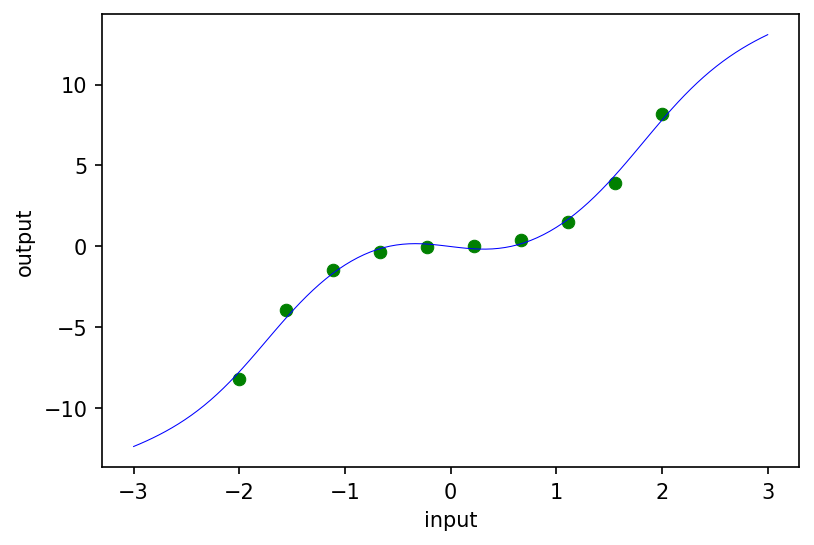

In [21]:
# Toy 1D dataset
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100,1))
targets = inputs**3 + 0.1 * inputs

# Hyperparameters
layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

# Init and train
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
    resnet_params = resnet_update(resnet_params, inputs,
                                  targets, step_size)

# Plot
fig = plt.figure(figsize=(6,4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color="green")

ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth),
        lw=0.5, color="blue")
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.show()
plt.close()

Neural ODE

In [22]:
def nn_dynamics(state, time, params):
    state_and_time = jnp.hstack([state, jnp.array(time)])
    return mlp(params, state_and_time)

def odenet(params, inputs):
    start_and_end_times = jnp.array([0.0, 1.0])
    init_state, final_state = odeint(nn_dynamics, inputs,
                                     start_and_end_times, params)
    return final_state

Train an neural ODE

In [23]:
batched_odenet = vmap(odenet, in_axes=(None, 0))
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
    preds = batched_odenet(params, inputs)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def ode_net_update(params, inputs, targets, step_size):
    grads = grad(odenet_loss)(params, inputs, targets)
    updates = []
    for (w, b), (dw, db) in zip(params, grads):
        updates += [(w - step_size*dw, b - step_size*db)]
    return updates

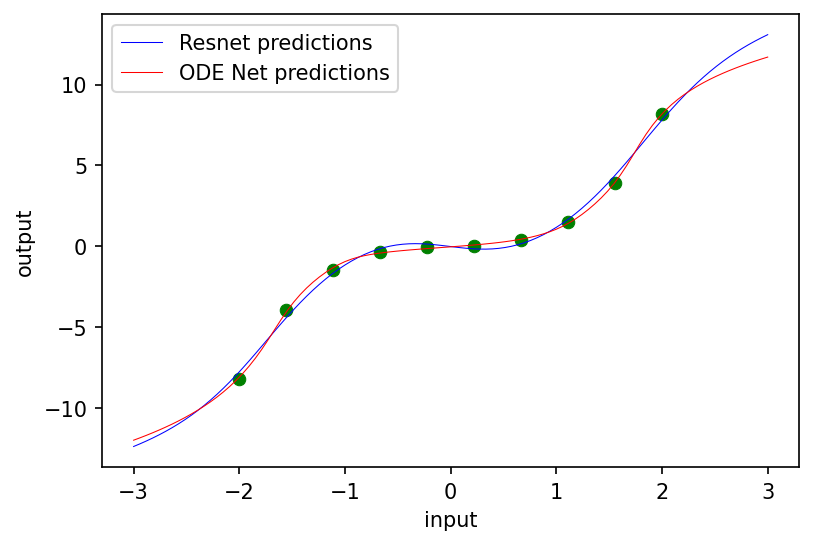

In [31]:
if True:
    odenet_params = init_random_params(param_scale, odenet_layer_sizes)

    for i in range(train_iters):
        odenet_params = ode_net_update(odenet_params, inputs,
                                       targets, step_size)


    fig = plt.figure(figsize=(6, 4), dpi=150)
    ax = fig.gca()
    ax.scatter(inputs, targets, lw=0.5, color="green")
    ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth),
            lw=0.5, color='blue')
    ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs),
            lw=0.5, color='red')
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    plt.legend(('Resnet predictions', 'ODE Net predictions'))
    plt.show()
    plt.close()

Activation Trajectories

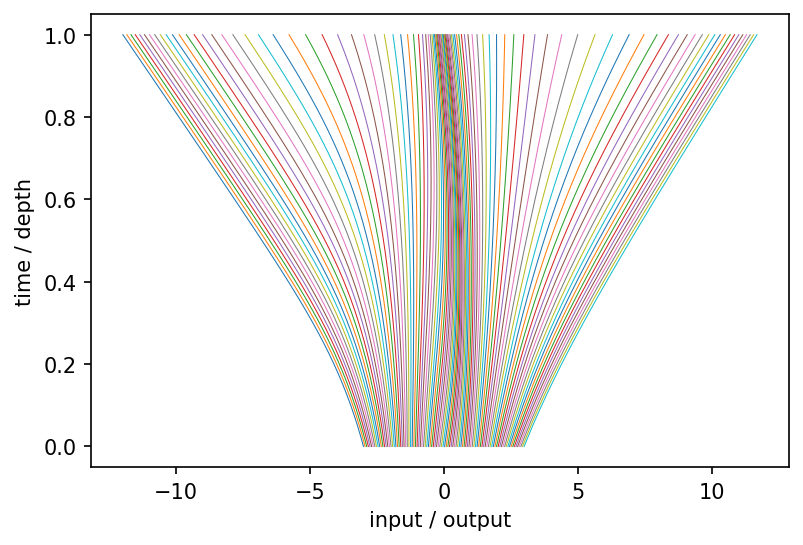

In [32]:
if True:
    times = jnp.linspace(0.0, 1.0, 200)

    fig = plt.figure(figsize=(6, 4), dpi=150)
    ax = fig.gca()

    @jit
    def odenet_times(params, inputs, times):
        def dynamics_func(state, time, params):
            return mlp(params, jnp.hstack([state, jnp.array(time)]))
        return odeint(dynamics_func, inputs, times, params)

    for i in fine_inputs:
        ax.plot(odenet_times(odenet_params, i, times), times, lw=0.5)

    ax.set_xlabel('input / output')
    ax.set_ylabel('time / depth')
    plt.show()
    plt.close()

In [26]:
def create_discrete_q_table(no_oberservation_bins, no_actions_bins, env):
    
    obs_space_size = len(env.observation_space.high)
    Q_bins = [jnp.linspace(env.observation_space.low[i], env.observation_space.high[i], no_oberservation_bins) for
              i in range(obs_space_size)]
    
    Q_table = np.random.uniform(low=env.action_space.low[0]-np.abs(env.action_space.low[0]*2),
                                high=env.action_space.low[0],
                               size=([no_oberservation_bins] * obs_space_size + [no_actions_bins]))
    
    #Q_table = np.zeros(shape=([no_oberservation_bins] * obs_space_size + [no_actions_bins]))
    
    return Q_bins, Q_table

def create_discrete_action_space(num_bins, env):
    
    action_space_bins = [jnp.linspace(env.action_space.low[i], env.action_space.high[i], num_bins) for
                         i in range(len(env.action_space.high))]
    
    return action_space_bins[0]

def discretize_state(state, bins):
    stateIndex = []
    for i in range(len(state)):
        stateIndex.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(stateIndex)

def discretize_actions(action, bins):
    return np.digitize(action, bins) - 1

In [27]:
#enviroment = gym.make("MountainCarContinuous-v0", render_mode="human")
#observation, info = enviroment.reset(seed=42)

no_actions_bins = 5
no_oberservation_bins = 20
action_bins = create_discrete_action_space(no_actions_bins, enviroment)
obs_bins, Q_table = create_discrete_q_table(no_oberservation_bins, no_actions_bins, enviroment)

sim_params = {"env": enviroment,
              "no_epochs": 250,
              "no_iterations": 10000,
              "no_oberservation_bins": no_oberservation_bins,
              "no_actions_bins": no_actions_bins, 
              "epsilon": 0.8, 
              "action_bins": action_bins,
              "Q_bins": obs_bins,
              "Q_table": Q_table}

In [28]:
def run_sim(sim_params):
    
    env = sim_params["env"]
    no_epochs = sim_params["no_epochs"]
    no_iterations = sim_params["no_iterations"]
    no_oberservation_bins = sim_params["no_oberservation_bins"]
    no_actions_bins = sim_params["no_actions_bins"]
    epsilon = sim_params["epsilon"]
    action_bins = sim_params["action_bins"]
    Q_bins = sim_params["Q_bins"]
    Q_table = sim_params["Q_table"]
    
    reward_values_per_epoch = []

    for epoch in range(no_epochs):
        observation, info = env.reset()
        total_reward = 0
        action_values = []
        reward_values = []

        for i in range(no_iterations):
            discrete_state = discretize_state(observation, Q_bins)

            epsilon_adj = epsilon - epsilon * (epoch / no_epochs)

            if np.random.uniform() < epsilon_adj:
                action = env.action_space.sample()
                action_index = np.digitize(env.action_space.sample(),
                                jnp.linspace(env.action_space.low[0], env.action_space.high[0], no_actions_bins))
            else:
                action_index = np.argmax(Q_table[discrete_state])
                action = action_bins[action_index]

            for _ in range(5):
                observation, reward, terminated, truncated, info = env.step([action])
            total_reward += reward
            discrete_new_state = discretize_state(observation, Q_bins)

            maxFutureQ = np.max(Q_table[discrete_new_state])  # estimate of optiomal future value
            currentQ = Q_table[discrete_state + (action_index,)]  # old value

            Q_value_new = 0.9 * currentQ + 0.1 * (reward + 0.9 * maxFutureQ)
            Q_table[discrete_state + (action_index, )] = Q_value_new  # Update qTable with new Q value

            action_values.append(action)
            reward_values.append(total_reward)

            if terminated or truncated:
                break
        
        reward_values_per_epoch.append(reward_values)

        if epoch % 10 == 0 and epoch > 1:
            print(f"Terminated after {i} iterations, reward: {total_reward}, epoch: {epoch}, eps: {epsilon_adj}")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.plot(action_values)
            ax1.set_title("action values")
            padded_values = np.array(list(zip_longest(*reward_values_per_epoch, fillvalue=0)))
            ax2.plot(np.mean(padded_values, axis=1))
            ax2.set_title("reward values")
            ax3.imshow(jnp.max(Q_table, axis=2), cmap='hot', interpolation='nearest')
            ax3.set_title("state values")
            plt.show()
            plt.close()
            reward_values_per_epoch = []

    env.close()

In [29]:
#run_sim(sim_params)